In [1]:
# allows to import own functions
import sys, os
path_name = os.getcwd()
root_project = os.path.split(path_name)[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
import joblib
sns.set()
%matplotlib inline

In [3]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

In [4]:
df = pd.read_pickle('../data/processed/simulation_results_rev2.pickle')
df

,initial_country,idx_country,R0,Tc,Tr,omega,total_infected,total_death,total_recovered
0,CHN,39,7.490802,2.538351,19.014286,0.151272,1.384908e+10,1.034035e+10,3.594968e+09
1,TUV,190,11.937003,0.746976,8.916655,0.005984,1.435180e+10,7.356705e+08,1.378797e+10
2,AGO,4,17.323523,0.693987,12.022300,0.105236,1.433590e+10,8.185045e+09,6.469450e+09
3,MMR,130,1.128232,12.798769,14.439975,0.023869,1.000000e+00,0.000000e+00,0.000000e+00
4,USA,195,3.636499,1.008687,3.668090,0.094586,1.381481e+10,3.565523e+09,1.027681e+10
...,...,...,...,...,...,...,...,...,...
1995,ESP,170,7.053822,0.923477,6.514044,0.036127,1.430948e+10,2.754938e+09,1.170661e+10
1996,AGO,4,8.588958,1.096072,9.414119,0.046043,1.433177e+10,4.397839e+09,1.014604e+10
1997,ESP,170,17.092381,0.938667,16.044060,0.027437,1.434249e+10,4.451077e+09,1.011149e+10
1998,FRA,65,1.667581,11.135983,18.570155,0.051834,1.000000e+00,0.000000e+00,0.000000e+00


In [5]:
df['total_death'] = df['total_death'] / 1000

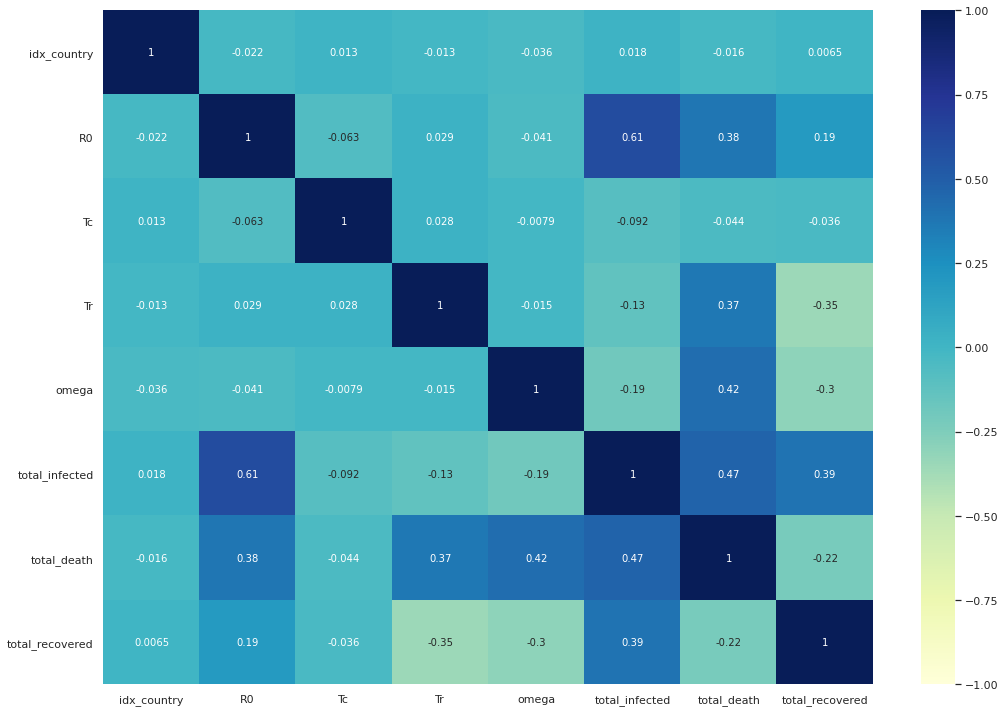

In [6]:
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(corr_matrix, vmax=1, vmin=-1, annot=True, cmap="YlGnBu", ax=ax)
plt.tight_layout()

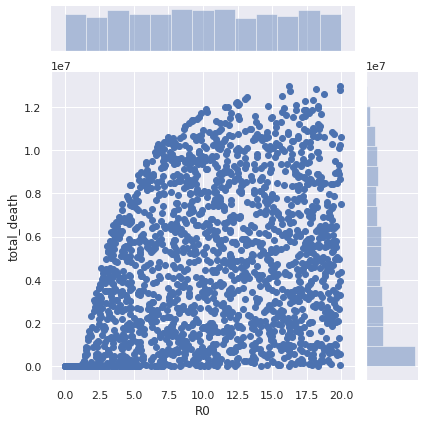

In [9]:
sns.jointplot(x=df['R0'], y=df['total_death'], kind='scatter')
plt.tight_layout()

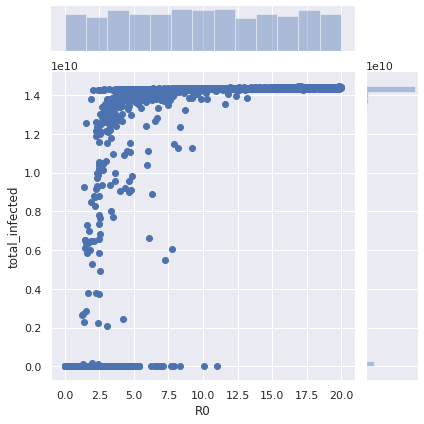

In [10]:
sns.jointplot(x=df['R0'], y=df['total_infected'], kind='scatter')
plt.tight_layout()

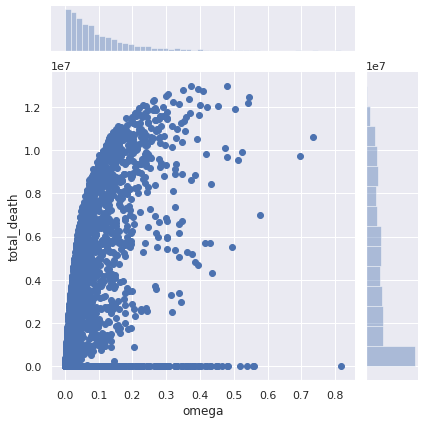

In [11]:
sns.jointplot(x=df['omega'], y=df['total_death'], kind='scatter')
plt.tight_layout()

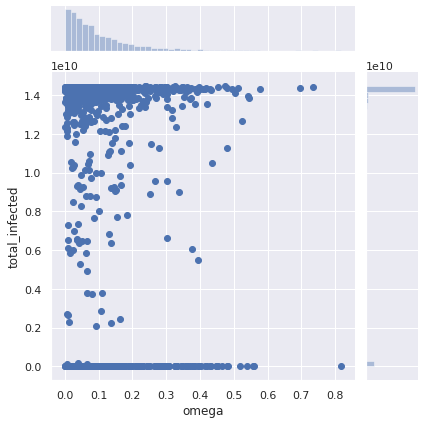

In [12]:
sns.jointplot(x=df['omega'], y=df['total_infected'], kind='scatter')
plt.tight_layout()

Parece que o bien se producen muchos infectados, o muy pocos, si pasa algo.. claro, depende de R0 el número de infectados! Si es bajo habrá pocos infectados.

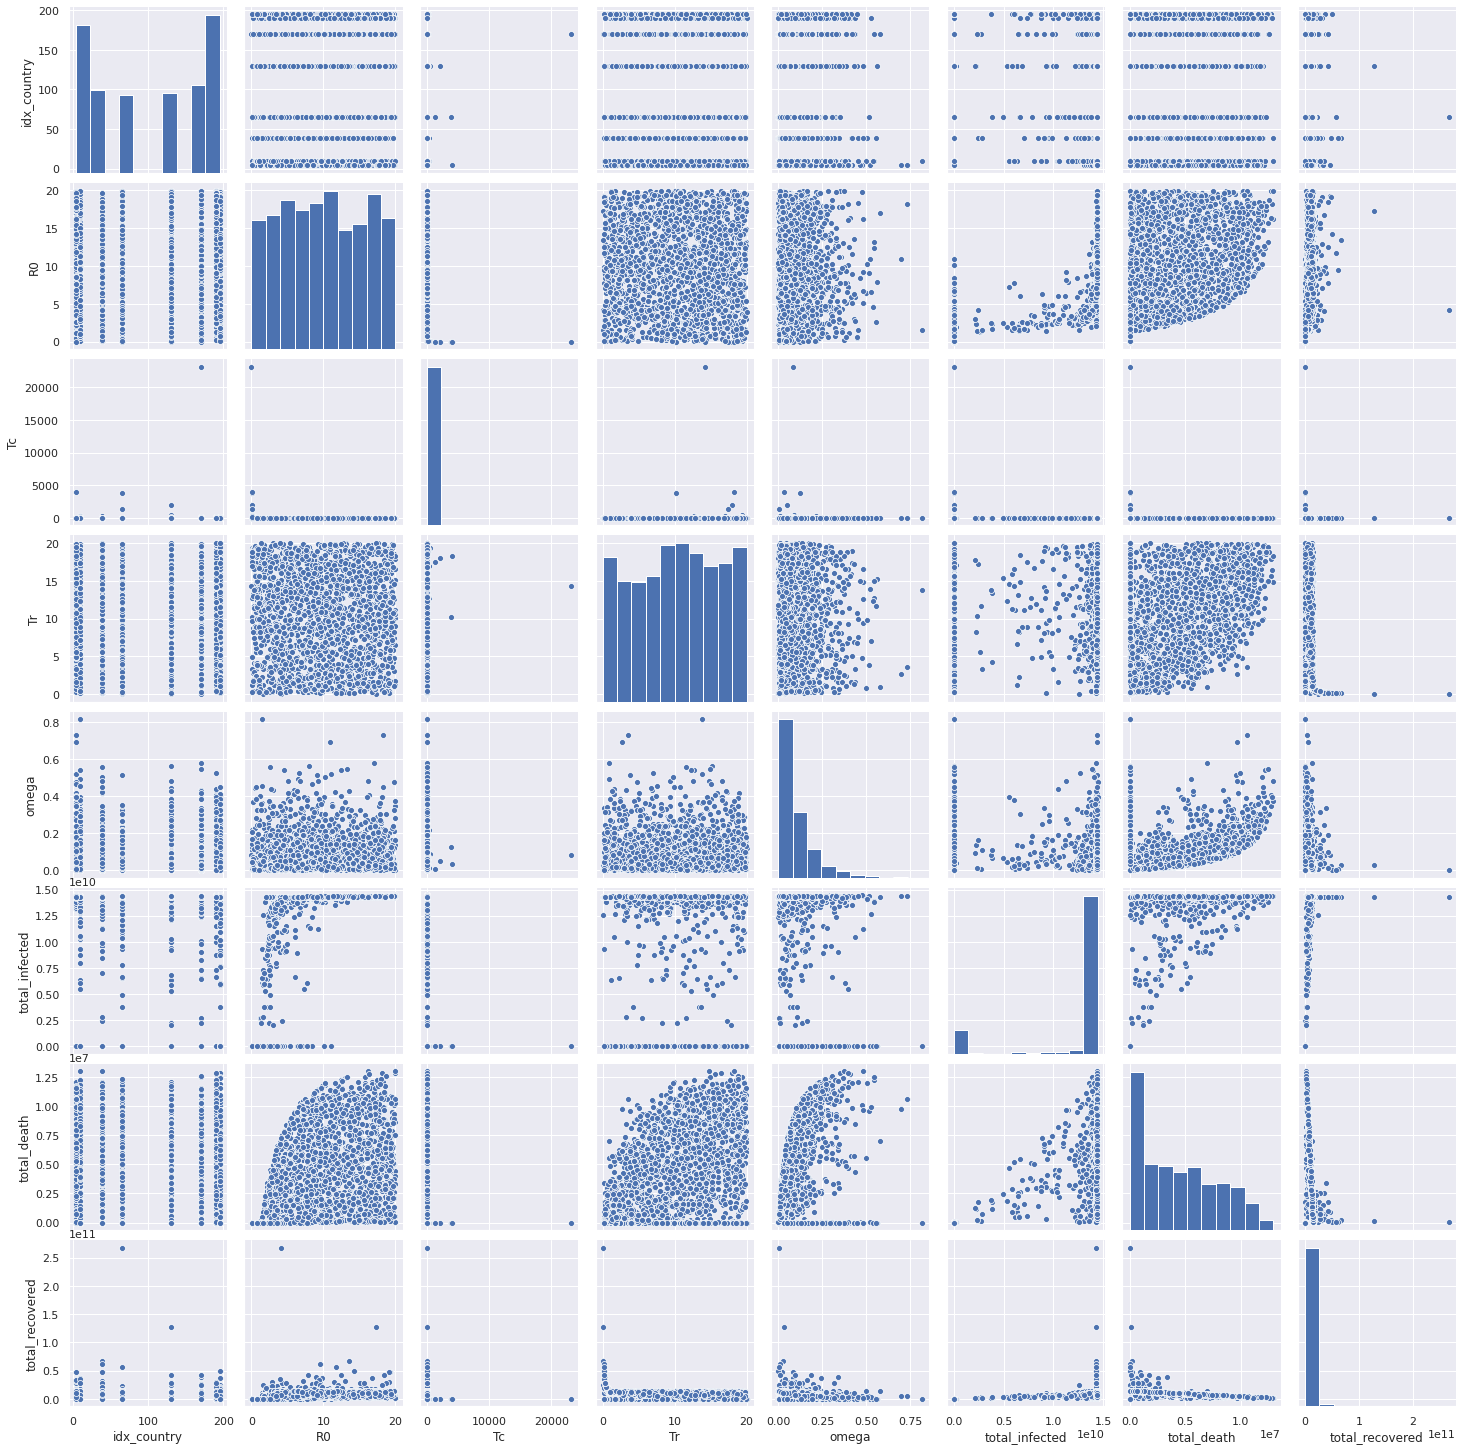

In [13]:
sns.pairplot(df)

## RANDOM FOREST

In [14]:
df

,initial_country,idx_country,R0,Tc,Tr,omega,total_infected,total_death,total_recovered
0,CHN,39,7.490802,2.538351,19.014286,0.151272,1.384908e+10,1.034035e+07,3.594968e+09
1,TUV,190,11.937003,0.746976,8.916655,0.005984,1.435180e+10,7.356705e+05,1.378797e+10
2,AGO,4,17.323523,0.693987,12.022300,0.105236,1.433590e+10,8.185045e+06,6.469450e+09
3,MMR,130,1.128232,12.798769,14.439975,0.023869,1.000000e+00,0.000000e+00,0.000000e+00
4,USA,195,3.636499,1.008687,3.668090,0.094586,1.381481e+10,3.565523e+06,1.027681e+10
...,...,...,...,...,...,...,...,...,...
1995,ESP,170,7.053822,0.923477,6.514044,0.036127,1.430948e+10,2.754938e+06,1.170661e+10
1996,AGO,4,8.588958,1.096072,9.414119,0.046043,1.433177e+10,4.397839e+06,1.014604e+10
1997,ESP,170,17.092381,0.938667,16.044060,0.027437,1.434249e+10,4.451077e+06,1.011149e+10
1998,FRA,65,1.667581,11.135983,18.570155,0.051834,1.000000e+00,0.000000e+00,0.000000e+00


In [15]:
# df_model = df.drop(['idx_country', 'total_infected', 'total_recovered'], axis=1)
df_model = df.drop(['initial_country','idx_country', 'total_infected', 'total_recovered'], axis=1)

df_model

,R0,Tc,Tr,omega,total_death
0,7.490802,2.538351,19.014286,0.151272,1.034035e+07
1,11.937003,0.746976,8.916655,0.005984,7.356705e+05
2,17.323523,0.693987,12.022300,0.105236,8.185045e+06
3,1.128232,12.798769,14.439975,0.023869,0.000000e+00
4,3.636499,1.008687,3.668090,0.094586,3.565523e+06
...,...,...,...,...,...
1995,7.053822,0.923477,6.514044,0.036127,2.754938e+06
1996,8.588958,1.096072,9.414119,0.046043,4.397839e+06
1997,17.092381,0.938667,16.044060,0.027437,4.451077e+06
1998,1.667581,11.135983,18.570155,0.051834,0.000000e+00


In [16]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

In [17]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, random_state=42)

In [18]:
categorical_pipe = Pipeline(
    [
        ('onehot', OneHotEncoder()),
    ]
)


preprocessing = ColumnTransformer([("cat", categorical_pipe, ["initial_country"])])

rnd_reg = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "regressor__n_estimators": n_estimators,
    "regressor__max_features": max_features,
    "regressor__max_depth": max_depth,
    "regressor__min_samples_split": min_samples_split,
    "regressor__min_samples_leaf": min_samples_leaf,
    "regressor__bootstrap": bootstrap,
}

random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [19]:
# gridsearch = RandomizedSearchCV(
#     rnd_reg, random_grid, random_state=42, n_iter=500, n_jobs=-1, verbose=2)
# gridsearch.fit(X_train_validation, y_train_validation)

# gridsearch = RandomizedSearchCV(
#     RandomForestRegressor(random_state=42), random_grid, random_state=42, n_iter=500, n_jobs=-1, verbose=2)
# gridsearch.fit(X_train_validation, y_train_validation)
# joblib.dump(gridsearch, '../models/gridsearch_randomf_deaths_rev2.pkl')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 13.1min finished


['../models/gridsearch_randomf_deaths_rev2.pkl']

In [20]:
gridsearch = joblib.load('../models/gridsearch_randomf_deaths_rev2.pkl')

In [21]:
results_searchcv(gridsearch, X_test, y_test)

The best score is:
0.950170840778221
The best parameters found are:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
The score in test is:
0.9386759762534072
The MAE is:
296447.01131980936
The RMSE is:
767331066042.6226
The explained variance score is:
0.9389268062281465


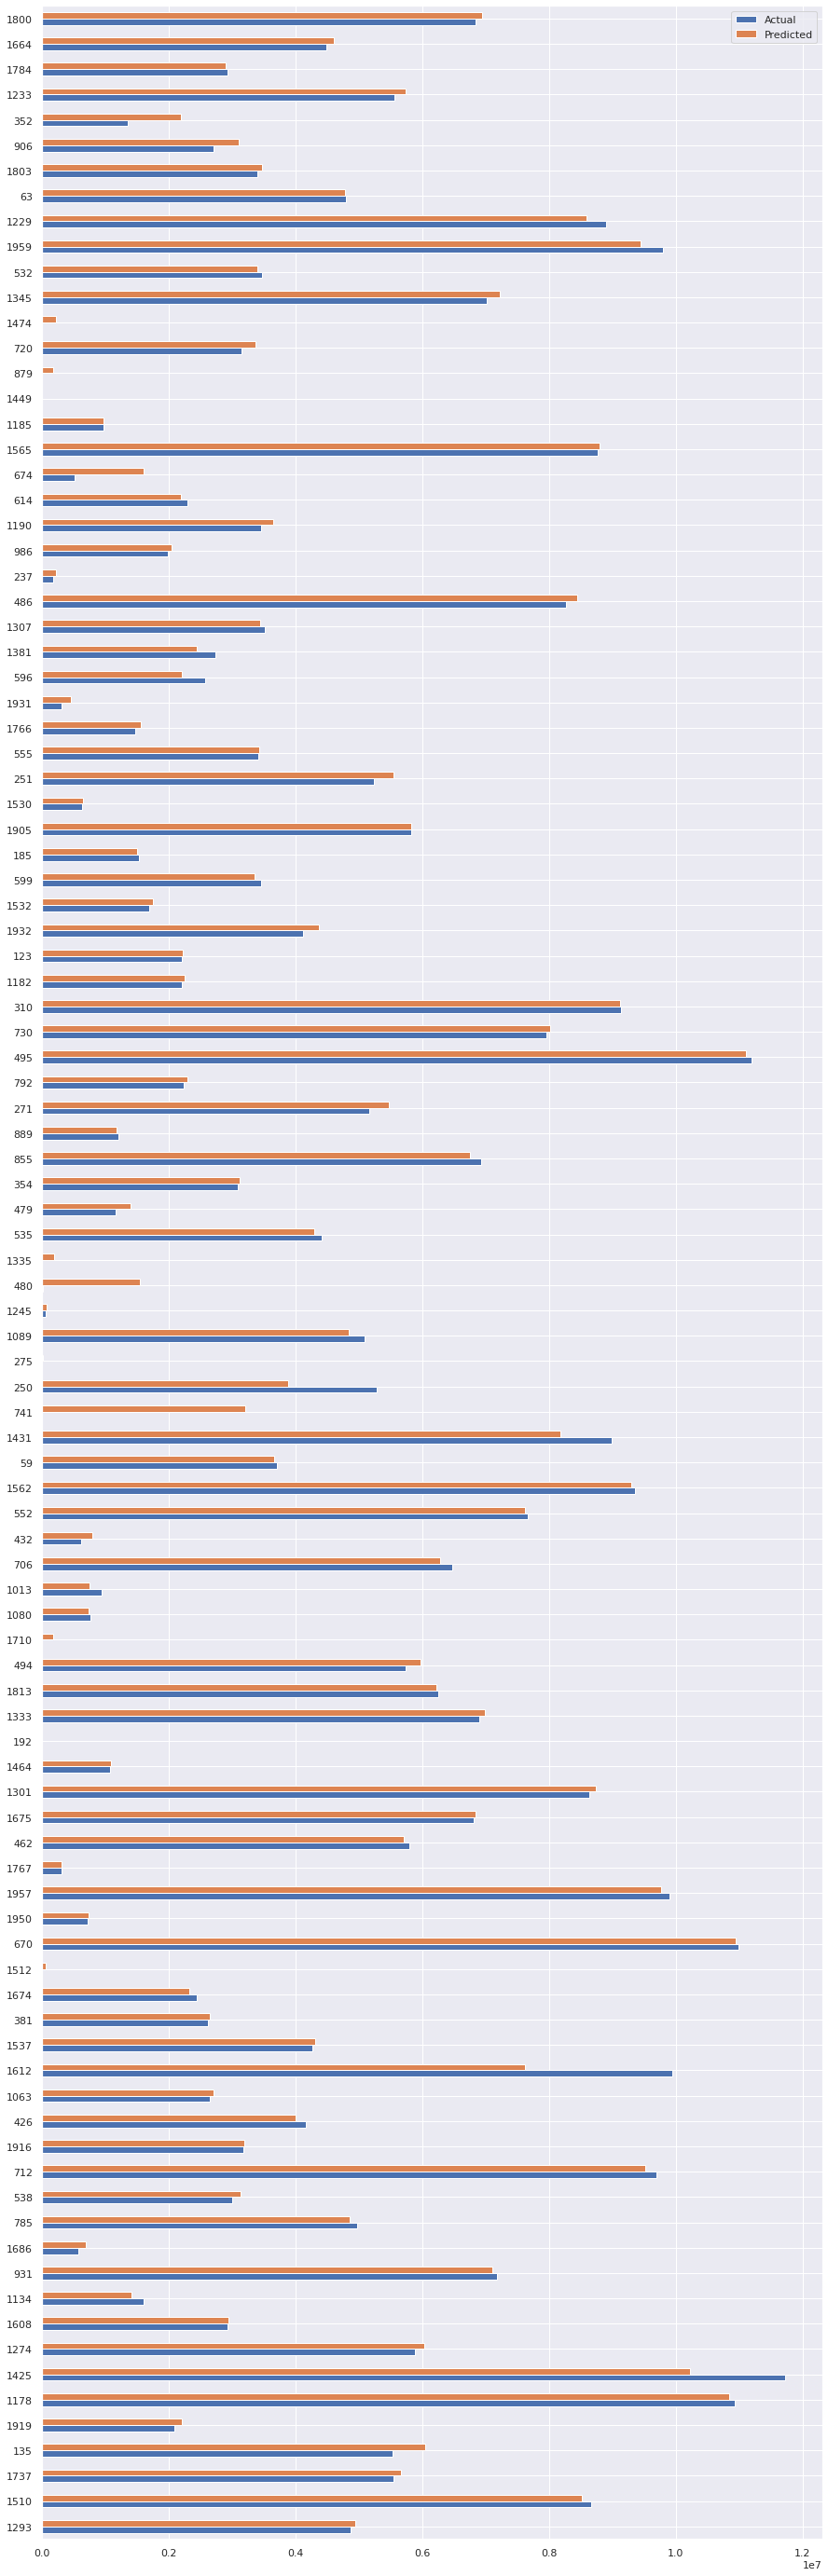

In [22]:
y_predicted = gridsearch.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()